In [10]:
import pandas as pd
import numpy as np
import labellines
import matplotlib.pyplot as plt
import seaborn as sns
NUM_COLORS = 6
cm = plt.get_cmap('Paired')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
import scipy
df_centile_boys = pd.read_csv('data/percentiles_chart_boys.csv',header=0)
df_centile_girls = pd.read_csv('data/percentiles_chart_girls.csv',header=0)
df_centile_boys_csa =pd.read_csv("data/percentiles_chart_boys_csa.csv", header=0)
df_centile_girls_csa =pd.read_csv("data/percentiles_chart_girls_csa.csv", header=0)


df_bch = pd.read_csv("data/bch/df_bch_accepted.csv", delimiter="," , header=0)
df_dmg = pd.read_csv("data/DMG_MRI_nifti/df_matched_dmg.csv", delimiter="," , header=0)
df_ant = pd.read_csv("data/ABCD-studies/abcd_bmi.csv", header=0)
df_hrm = pd.read_csv("data/ABCD-studies/abcd_hsss01.csv", header=0)
df_step = pd.read_csv("data/ABCD-studies/abcd_steps.csv", header=0)
df_cals = pd.read_csv("data/ABCD-studies/abcd_cals.csv", header=0)

def closest_value(input_list, input_value):
    arr = np.asarray(input_list)
    i = (np.abs(arr - input_value)).argmin()
    return arr[i], i

def find_centile(input_tmt, age, df):
    #print("TMT:",input_tmt,"Age:", age)
    val,i=closest_value(df['x'],age)
    
    centile = 'out of range'
    if input_tmt<df.iloc[i]['X3']:
        centile ='< 3'
    if df.iloc[i]['X3']<=input_tmt<df.iloc[i]['X10']:
        centile ='3-10'
    if df.iloc[i]['X10']<=input_tmt<df.iloc[i]['X25']:
        centile ='10-25'
    if df.iloc[i]['X25']<=input_tmt<df.iloc[i]['X50']:
        centile ='25-50'
    if df.iloc[i]['X50']<=input_tmt<df.iloc[i]['X75']:
        centile ='50-75'
    if df.iloc[i]['X75']<=input_tmt<df.iloc[i]['X90']:
        centile ='75-90'
    if df.iloc[i]['X90']<=input_tmt<df.iloc[i]['X97']:
        centile ='90-97'
    if input_tmt>df.iloc[i]['X97']:
        centile ='97>'
    #print(val,i,centile)
    return centile

def find_exact_percentile_return_number(input_tmt, age, df):
    #print("TMT:",input_tmt,"Age:", age)
    val,i=closest_value(df['x'],age)
    
    mu = df.iloc[i]['mu']
    sigma = df.iloc[i]['sigma']
    nu = df.iloc[i]['nu']
    #tau = df.iloc[i]['tau']
    
    if nu!=0:
        z = ((input_tmt/mu)**(nu)-1)/(nu*sigma)
    else:
        z = 1/sigma * math.log(input_tmt/mu)
    percentile = scipy.stats.norm.cdf(z)
    return round(percentile*100,2)

In [199]:
find_exact_percentile_return_number(8.08,9,df_centile_girls)

8.13

In [133]:
cohort=[]
cohort_csa=[]
for i in range(0, len(df_bch)):
    if round(df_bch['Age MRI'].iloc[i])< 4:
        age = 4
    else:
        age = round(df_bch['Age MRI'].iloc[i])
        
    if df_bch['Sex'].iloc[i]=='Female':
        sex=2
        centile_tmt = find_exact_percentile_return_number(df_bch['TMT'].iloc[i], age,df_centile_girls)
        centile_csa =find_exact_percentile_return_number(df_bch['CSA'].iloc[i], age,df_centile_girls_csa)
    else:
        sex=1
        centile_tmt = find_exact_percentile_return_number(df_bch['TMT'].iloc[i], age, df_centile_boys)
        centile_csa =find_exact_percentile_return_number(df_bch['CSA'].iloc[i], age,df_centile_boys_csa)
    
    cohort.append([df_bch['BCH MRN'].iloc[i],
                           sex,
                           df_bch['Age MRI'].iloc[i],
                            df_bch['TMT'].iloc[i],
                   centile_tmt,#centile_csa,
                   'pLGG',"Cancer DX"])
    
    cohort_csa.append([df_bch['BCH MRN'].iloc[i],
                           sex,
                           df_bch['Age MRI'].iloc[i],
                            df_bch['TMT'].iloc[i],
                   centile_csa,
                   'pLGG',"Cancer DX"])

    #break
    

In [135]:
for i in range(0, len(df_dmg)):
    if round(df_dmg['years_at_scan'].iloc[i])< 4:
        age = 4
    else:
        age = round(df_dmg['years_at_scan'].iloc[i])
        
    if df_dmg['sex'].iloc[i]=='F':
        sex=2
        centile_dx = find_exact_percentile_return_number(df_dmg['tmt'].iloc[i], age,df_centile_girls)
        
        centile_csa =find_exact_percentile_return_number(df_bch['CSA'].iloc[i], age,df_centile_girls_csa)

    else:
        sex=1
        centile_dx = find_exact_percentile_return_number( df_dmg['tmt'].iloc[i], age, df_centile_boys)
       
    
    cohort.append([df_dmg['id'].iloc[i],
                           sex,
                           df_dmg['years_at_scan'].iloc[i],
                            df_dmg['tmt'].iloc[i],
                   centile_dx,
                   'DMG',"Cancer DX"])
    #break
    

In [201]:
df_ant['TMT-BMI adj'] = df_ant["TMT PRED AVG filtered"]/df_ant['BMI']
df_ant['TMT-Height adj'] = df_ant["TMT PRED AVG filtered"]/df_ant['Height']
dict_weight_norms = {
    1:
    {8:{'min':46,'max':78},
      9:{'min':46,'max':78},
      10:{'min':54,'max':102},
      11:{'min':54,'max':102},
      12:{'min':66,'max':130},
      13:{'min':66,'max':130}},
    
    2:
    {8:{'min':44,'max':80},
      9:{'min':44,'max':80},
      10:{'min':54,'max':106},
      11:{'min':54,'max':106},
      12:{'min':68,'max':138},
      13:{'min':68,'max':138}
      }
}

dict_height_norms = {
    1:
    {8:{'min':47,'max':54},
      9:{'min':47,'max':54},
      10:{'min':50,'max':59},
      11:{'min':50,'max':59},
      12:{'min':54,'max':64},
      13:{'min':54,'max':64}},
    
    2:
    {8:{'min':47,'max':54},
      9:{'min':47,'max':54},
      10:{'min':50,'max':59},
      11:{'min':50,'max':59},
      12:{'min':55,'max':64},
      13:{'min':55,'max':64}
      }
}


In [136]:
for i in range(0, len(df_ant)): 
    if df_ant['BMI'].iloc[i] >30:
        age=round(df_ant['Age'].iloc[i])
        if df_ant['gender'].iloc[i]==2:
            sex=2
            centile_dx = find_exact_percentile_return_number(df_ant['TMT PRED AVG filtered'].iloc[i], age,df_centile_girls)

        else:
            sex=1
            centile_dx = find_exact_percentile_return_number(df_ant['TMT PRED AVG filtered'].iloc[i], age, df_centile_boys)

        cohort.append([df_ant['id'].iloc[i],
                               sex,
                               df_ant['Age'].iloc[i],
                                df_ant['TMT PRED AVG filtered'].iloc[i],
                       centile_dx,
                       'Obese',"BMI"])
        
    elif df_ant['BMI'].iloc[i] <14:
        age=round(df_ant['Age'].iloc[i])
        if df_ant['gender'].iloc[i]==2:
            sex=2
            centile_dx = find_exact_percentile_return_number(df_ant['TMT PRED AVG filtered'].iloc[i], age,df_centile_girls)

        else:
            sex=1
            centile_dx = find_exact_percentile_return_number(df_ant['TMT PRED AVG filtered'].iloc[i], age, df_centile_boys)

        cohort.append([df_ant['id'].iloc[i],
                               sex,
                               df_ant['Age'].iloc[i],
                                df_ant['TMT PRED AVG filtered'].iloc[i],
                       centile_dx,
                       'Underweight',"BMI"])
    else:
        age=round(df_ant['Age'].iloc[i])
        if df_ant['gender'].iloc[i]==2:
            sex=2
            centile_dx = find_exact_percentile_return_number(df_ant['TMT PRED AVG filtered'].iloc[i], age,df_centile_girls)

        else:
            sex=1
            centile_dx = find_exact_percentile_return_number(df_ant['TMT PRED AVG filtered'].iloc[i], age, df_centile_boys)

        cohort.append([df_ant['id'].iloc[i],
                               sex,
                               df_ant['Age'].iloc[i],
                                df_ant['TMT PRED AVG filtered'].iloc[i],
                       centile_dx,
                       'Normal BMI',"BMI"])
    #break
    

/tmp/ipykernel_3036824/314036135.py:62: RuntimeWarning: divide by zero encountered in double_scalars
  z = ((input_tmt/mu)**(nu)-1)/(nu*sigma)


In [137]:
dict_dhea_norms = {
    1:
    {8:{'min':11,'max':120},
      9:{'min':11,'max':120},
      10:{'min':11,'max':120},
      11:{'min':14,'max':323},
      12:{'min':5.5,'max':(312+323)/2},
      13:{'min':5.5,'max':312}},
    
    2:
    {8:{'min':16,'max':96},
      9:{'min':16,'max':96},
      10:{'min':22,'max':184},
      11:{'min':11,'max':296},
      12:{'min':17,'max':343},
      13:{'min':(17+57)/2,'max':(343+395)/2}
      }
}

act_list2 = []
for idx in range(0, df_hrm.shape[0]):
    
    dhea = df_hrm.iloc[idx]['DHEA']
    gender =  df_hrm.iloc[idx]['gender']
    age = df_hrm.iloc[idx]['Age']
    first_q = dict_dhea_norms[gender][age]['min']
    third_q = dict_dhea_norms[gender][age]['max']
    
    if first_q > dhea:
        act_list2.append('<2.5%')
    elif first_q < dhea < third_q:
        act_list2.append('2.5%-97.5%')
    elif dhea > third_q:
        act_list2.append('97.5%>')
    else:
        act_list2.append("No data")
        
df_hrm['DHEA Reference Range'] = act_list2
df_hrm = df_hrm[df_hrm['DHEA Reference Range'] != "No data"]
df_hrm['Sex'] = df_hrm['gender'].map({2:'Female',1:'Male'})

for i in range(0, len(df_hrm)): 
    if df_hrm['DHEA Reference Range'].iloc[i]=='<2.5%':
        age=round(df_hrm['Age'].iloc[i])
        if df_hrm['gender'].iloc[i]==2:
            sex=2
            centile_dx = find_exact_percentile_return_number(df_hrm['TMT PRED AVG filtered'].iloc[i], age,df_centile_girls)

        else:
            sex=1
            centile_dx = find_exact_percentile_return_number(df_hrm['TMT PRED AVG filtered'].iloc[i], age, df_centile_boys)

        cohort.append([df_hrm['id'].iloc[i],
                               sex,
                               df_hrm['Age'].iloc[i],
                                df_hrm['TMT PRED AVG filtered'].iloc[i],
                       centile_dx,
                       'DHEA <2.5%','DHEA'])
    elif df_hrm['DHEA Reference Range'].iloc[i]=='97.5%>':
        age=round(df_hrm['Age'].iloc[i])
        if df_hrm['gender'].iloc[i]==2:
            sex=2
            centile_dx = find_exact_percentile_return_number(df_hrm['TMT PRED AVG filtered'].iloc[i], age,df_centile_girls)

        else:
            sex=1
            centile_dx = find_exact_percentile_return_number(df_hrm['TMT PRED AVG filtered'].iloc[i], age, df_centile_boys)

        cohort.append([df_hrm['id'].iloc[i],
                               sex,
                               df_hrm['Age'].iloc[i],
                                df_hrm['TMT PRED AVG filtered'].iloc[i],
                       centile_dx,
                       'DHEA 97.5%>','DHEA'])
    else:
        age=round(df_hrm['Age'].iloc[i])
        if df_hrm['gender'].iloc[i]==2:
            sex=2
            centile_dx = find_exact_percentile_return_number(df_hrm['TMT PRED AVG filtered'].iloc[i], age,df_centile_girls)

        else:
            sex=1
            centile_dx = find_exact_percentile_return_number(df_hrm['TMT PRED AVG filtered'].iloc[i], age, df_centile_boys)

        cohort.append([df_hrm['id'].iloc[i],
                               sex,
                               df_hrm['Age'].iloc[i],
                                df_hrm['TMT PRED AVG filtered'].iloc[i],
                       centile_dx,
                       'Normal DHEA','DHEA'])
        
    #break
    

/tmp/ipykernel_3036824/314036135.py:62: RuntimeWarning: divide by zero encountered in double_scalars
  z = ((input_tmt/mu)**(nu)-1)/(nu*sigma)


In [138]:
df_step['Sex'] = df_step['Gender'].map({2:'Female',1:'Male'})

healthy_male_lower =  12000#7100#12000
healthy_male_higher = 16000#11000#16000

healthy_female_lower = 10000#7100#10000
healthy_female_higher = 13000#11000#13000

steps_list =[]
for idx in range(0, df_step.shape[0]):
    row = df_step.iloc[idx]['Total steps']
    gender = df_step.iloc[idx]['Gender']
    
    if healthy_male_lower > row and gender==1:
        steps_list.append('Low steps')
    elif healthy_male_lower < row < healthy_male_higher and gender==1: 
        steps_list.append('Normal steps')
    elif row > healthy_male_higher and gender==1:
        steps_list.append('High steps')
        
    elif healthy_female_lower > row and gender==2:
        steps_list.append('Low steps')
    elif healthy_female_lower < row < healthy_female_higher and gender==2: 
        steps_list.append('Normal steps')
    elif row > healthy_female_higher and gender==2:
        steps_list.append('High steps')
        
    else:
        steps_list.append("No data")
        
df_step['Step levels'] = steps_list
df_step=df_step[df_step['Step levels']!="No data"]

for i in range(0, len(df_step)): 
    if df_step['Step levels'].iloc[i]=='Low steps':
        age=round(df_step['Age'].iloc[i])
        if df_step['Gender'].iloc[i]==2:
            sex=2
            centile_dx = find_exact_percentile_return_number(df_step['TMT PRED AVG filtered'].iloc[i], age,df_centile_girls)

        else:
            sex=1
            centile_dx = find_exact_percentile_return_number(df_step['TMT PRED AVG filtered'].iloc[i], age, df_centile_boys)

        cohort.append([df_step['id'].iloc[i],
                               sex,
                               df_step['Age'].iloc[i],
                                df_step['TMT PRED AVG filtered'].iloc[i],
                       centile_dx,
                       'Low steps','Steps'])
        
    if df_step['Step levels'].iloc[i]=='High steps':
        age=round(df_step['Age'].iloc[i])
        if df_step['Gender'].iloc[i]==2:
            sex=2
            centile_dx = find_exact_percentile_return_number(df_step['TMT PRED AVG filtered'].iloc[i], age,df_centile_girls)

        else:
            sex=1
            centile_dx = find_exact_percentile_return_number(df_step['TMT PRED AVG filtered'].iloc[i], age, df_centile_boys)

        cohort.append([df_step['id'].iloc[i],
                               sex,
                               df_step['Age'].iloc[i],
                                df_step['TMT PRED AVG filtered'].iloc[i],
                       centile_dx,
                       'High steps','Steps'])
    else:
        age=round(df_step['Age'].iloc[i])
        if df_step['Gender'].iloc[i]==2:
            sex=2
            centile_dx = find_exact_percentile_return_number(df_step['TMT PRED AVG filtered'].iloc[i], age,df_centile_girls)

        else:
            sex=1
            centile_dx = find_exact_percentile_return_number(df_step['TMT PRED AVG filtered'].iloc[i], age, df_centile_boys)

        cohort.append([df_step['id'].iloc[i],
                               sex,
                               df_step['Age'].iloc[i],
                                df_step['TMT PRED AVG filtered'].iloc[i],
                       centile_dx,
                       'Normal steps','Steps'])
        

    #break

/tmp/ipykernel_3036824/314036135.py:62: RuntimeWarning: divide by zero encountered in double_scalars
  z = ((input_tmt/mu)**(nu)-1)/(nu*sigma)


In [139]:
df_cals = pd.read_csv("data/ABCD-studies/abcd_cals.csv", header=0)
healthy_male_lower = 1600
healthy_male_higher = 2600

healthy_female_lower = 1400
healthy_female_higher = 2200

cals_list =[]
for idx in range(0, df_cals.shape[0]):
    row = df_cals.iloc[idx]['Dt_kcal']
    gender = df_cals.iloc[idx]['Gender']
    
    if healthy_male_lower > row and gender==1:
        cals_list.append('Low kcal/d')
    elif healthy_male_lower < row < healthy_male_higher and gender==1: 
        cals_list.append('Normal kcal/d')
    elif row > healthy_male_higher and gender==1:
        cals_list.append('High kcal/d')
        
    elif healthy_female_lower > row and gender==2:
        cals_list.append('Low kcal/d')
    elif healthy_female_lower < row < healthy_female_higher and gender==2: 
        cals_list.append('Normal kcal/d')
    elif row > healthy_female_higher and gender==2:
        cals_list.append('High kcal/d')
        
    else:
        cals_list.append("No data")
        
df_cals['kcal/d levels'] = cals_list

for i in range(0, len(df_cals)): 
    if df_cals['kcal/d levels'].iloc[i]=='Low kcal/d':
        age=round(df_cals['Age'].iloc[i])
        if df_cals['Gender'].iloc[i]==2:
            sex=2
            centile_dx = find_exact_percentile_return_number(df_cals['TMT PRED AVG filtered'].iloc[i], age,df_centile_girls)

        else:
            sex=1
            centile_dx = find_exact_percentile_return_number(df_cals['TMT PRED AVG filtered'].iloc[i], age, df_centile_boys)

        cohort.append([df_cals['id'].iloc[i],
                               sex,
                               df_cals['Age'].iloc[i],
                                df_cals['TMT PRED AVG filtered'].iloc[i],
                       centile_dx,
                       'Low kcal/d','kcal/d'])
    if df_cals['kcal/d levels'].iloc[i]=='High kcal/d':
        age=round(df_cals['Age'].iloc[i])
        if df_cals['Gender'].iloc[i]==2:
            sex=2
            centile_dx = find_exact_percentile_return_number(df_cals['TMT PRED AVG filtered'].iloc[i], age,df_centile_girls)

        else:
            sex=1
            centile_dx = find_exact_percentile_return_number(df_cals['TMT PRED AVG filtered'].iloc[i], age, df_centile_boys)

        cohort.append([df_cals['id'].iloc[i],
                               sex,
                               df_cals['Age'].iloc[i],
                                df_cals['TMT PRED AVG filtered'].iloc[i],
                       centile_dx,
                       'High kcal/d','kcal/d'])
    if df_cals['kcal/d levels'].iloc[i]=='Normal kcal/d':
        age=round(df_cals['Age'].iloc[i])
        if df_cals['Gender'].iloc[i]==2:
            sex=2
            centile_dx = find_exact_percentile_return_number(df_cals['TMT PRED AVG filtered'].iloc[i], age,df_centile_girls)

        else:
            sex=1
            centile_dx = find_exact_percentile_return_number(df_cals['TMT PRED AVG filtered'].iloc[i], age, df_centile_boys)

        cohort.append([df_cals['id'].iloc[i],
                               sex,
                               df_cals['Age'].iloc[i],
                                df_cals['TMT PRED AVG filtered'].iloc[i],
                       centile_dx,
                       'Normal kcal/d','kcal/d'])
        
   

In [17]:
cohort_df=pd.DataFrame(cohort,columns=['ID',"Sex","Age",'TMT',"%tile",'Cohort',"Category"])
cohort_df

,ID,Sex,Age,TMT,%tile,Cohort,Category
0,4182189,1,23.331507,14.32,52.87,pLGG,Cancer DX
1,4524098,2,3.600000,7.94,25.34,pLGG,Cancer DX
2,4724421,1,14.487671,11.62,35.00,pLGG,Cancer DX
3,4291698,1,10.284932,7.96,2.61,pLGG,Cancer DX
4,2088644,2,17.528767,15.94,91.42,pLGG,Cancer DX
...,...,...,...,...,...,...,...
67800,NDARINV1535421B,2,11.000000,13.33,79.70,Low kcal/d,kcal/d
67801,NDARINV158CYMLK,1,11.000000,10.62,34.24,Low kcal/d,kcal/d
67802,NDARINV1378XGLA,2,11.000000,11.97,60.56,Low kcal/d,kcal/d
67803,NDARINV13GH02YK,2,11.000000,8.56,8.32,Low kcal/d,kcal/d


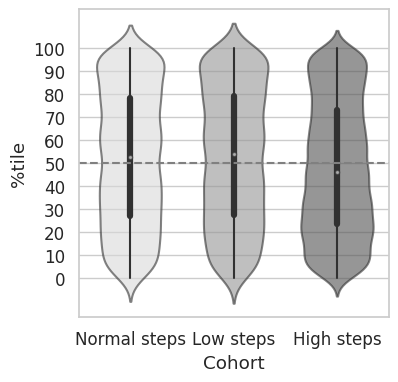

In [178]:
f, ax = plt.subplots(figsize=(4, 4))

sns.set(style="whitegrid",font_scale= 1.1)
cohort_df['N'] = (cohort_df['Cohort'].map(cohort_df['Cohort'].value_counts())).astype(int)

def add_median_labels(ax, fmt='.1f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='ultralight', color='black',size= 10)
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=0.5, foreground=median.get_color()),
            path_effects.Normal(),
        ])
        
cohort_df['Gender'] = cohort_df['Sex'].map({2:'Female',1:'Male'})
ax=sns.violinplot( y=cohort_df['%tile'],x=cohort_df['Cohort'],
                    data=cohort_df,dodge=False,
               #hue='Category',
                  width=0.7,
               palette = 'Greys',
                  alpha=0.3,
               #cut=0,
                  order =[#'Normal BMI','BMI<14','BMI>30',],
                         #[ 'Normal DHEA','DHEA <2.5%','DHEA 97.5%>'],
                          'Normal steps','Low steps','High steps'],
                          #['Normal kcal/d','Low kcal/d','High kcal/d'],
                         #['pLGG','DMG'],
                saturation = 4)
plt.setp(ax.collections, alpha=.6)
#plt.setp(ax.collections, alpha=.8)
#plt.legend(loc='upper right', title='Category',bbox_to_anchor=(1.3, 1.05))
#add_median_labels(ax)
ax.set_yticks(range(0,101,10))
ax.axhline(y = 50, color = 'gray',linestyle="--")
#ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=True,
#                     bottom=True, top=False, left=True, right=True)
#plt.xticks(rotation=90)
plt.show()

[None, None, None, None, None, None]

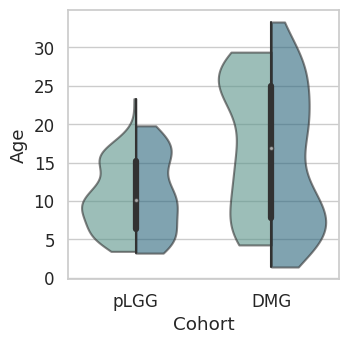

In [195]:
f, ax = plt.subplots(figsize=(3.5, 3.5))

sns.set(style="whitegrid",font_scale= 1.1)

cohort_df[cohort_df['Category']=='Cancer DX']
ax= sns.violinplot(data=cohort_df[cohort_df['Category']=='Cancer DX'], x="Cohort", y="Age",#,hue='Cohort',
                  width=0.8,
                   cut=0,
                   hue='Gender',
                   legend=False, 
               palette = 'crest',split=True,
                #linewidth=3,
                   alpha=0.5)
plt.legend([],[], frameon=False)

#ax.set_yticks(range(0,101,10))
#ax.axhline(y = 50, color = 'gray',linestyle="--")

plt.setp(ax.collections, alpha=.6)

In [204]:
cohort_df[cohort_df['Cohort']=='pLGG'].describe()

,Sex,Age,TMT,%tile,N
count,144.000000,144.000000,144.000000,144.000000,144.0
mean,1.430556,10.649486,9.944653,33.328472,144.0
std,0.496882,4.703778,2.998376,29.771142,0.0
min,1.000000,3.224658,2.260000,0.000000,144.0
25%,1.000000,6.303425,7.967500,6.622500,144.0
50%,1.000000,10.147945,10.050000,26.720000,144.0
75%,2.000000,15.235616,11.625000,52.952500,144.0
max,2.000000,23.331507,19.600000,99.040000,144.0


In [206]:
cohort_df[cohort_df['Cohort']=='pLGG']['Sex'].value_counts(normalize=True)

1    0.569444
2    0.430556
Name: Sex, dtype: float64

In [205]:
cohort_df[cohort_df['Cohort']=='DMG'].describe()

,Sex,Age,TMT,%tile,N
count,121.000000,121.000000,121.000000,121.000000,121.0
mean,1.545455,16.341039,9.916694,30.118595,121.0
std,0.500000,8.964778,4.091248,30.480414,0.0
min,1.000000,1.416438,0.000000,0.000000,121.0
25%,1.000000,7.819178,7.670000,1.950000,121.0
50%,2.000000,16.857534,9.860000,20.630000,121.0
75%,2.000000,25.046575,12.300000,44.070000,121.0
max,2.000000,33.317808,20.860000,99.940000,121.0


In [152]:
cohort_df[(cohort_df['Category']=='BMI')&(cohort_df['Cohort']=='Healthy')]

,ID,Sex,Age,TMT,%tile,Cohort,Category,N,Gender


In [154]:
cohort_df['Category'].value_counts()

Steps        33636
BMI          17713
DHEA         13256
kcal/d        2935
Cancer DX      265
Name: Category, dtype: int64

In [155]:
cohort_df['Cohort'].value_counts()

High steps       22366
Normal BMI       16658
Normal DHEA      11437
Normal steps      6670
Low steps         4600
Low kcal/d        2376
DHEA 97.5%>       1020
DHEA <2.5%         799
BMI>30             589
Normal kcal/d      512
BMI<14             466
pLGG               144
DMG                121
High kcal/d         47
Name: Cohort, dtype: int64

In [179]:
from scipy import stats
a =[]
b=[]
p_val = []
unique_cols=[#'Normal DHEA','DHEA <2.5%','DHEA 97.5%>',
    #'Normal BMI','BMI<14','BMI>30',
                         'Normal steps','Low steps','High steps',]
                         # 'Normal kcal/d','Low kcal/d','High kcal/d',]
                         #'pLGG','DMG']
for i in unique_cols:
    for j in unique_cols:  
        stat,p=stats.mannwhitneyu(cohort_df[cohort_df['Cohort']==i]['%tile'], 
              cohort_df[cohort_df['Cohort']==j]['%tile'])# ranksums
        a.append(i)
        b.append(j)
        p_val.append(p)
df_p = pd.DataFrame()
df_p['A']=a
df_p['B']=b
df_p['p']=p_val
df_p

,A,B,p
0,Normal steps,Normal steps,1.000000e+00
1,Normal steps,Low steps,1.944441e-01
2,Normal steps,High steps,4.838168e-22
3,Low steps,Normal steps,1.944441e-01
4,Low steps,Low steps,1.000000e+00
5,Low steps,High steps,9.699733e-23
6,High steps,Normal steps,4.838168e-22
7,High steps,Low steps,9.699733e-23
8,High steps,High steps,1.000000e+00


/tmp/ipykernel_3036824/615632643.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ax=sns.heatmap(df_p.pivot('A','B','p'), annot=True, center=0.05,)


[Text(0.5, 73.24999999999999, ''), Text(88.24999999999999, 0.5, '')]

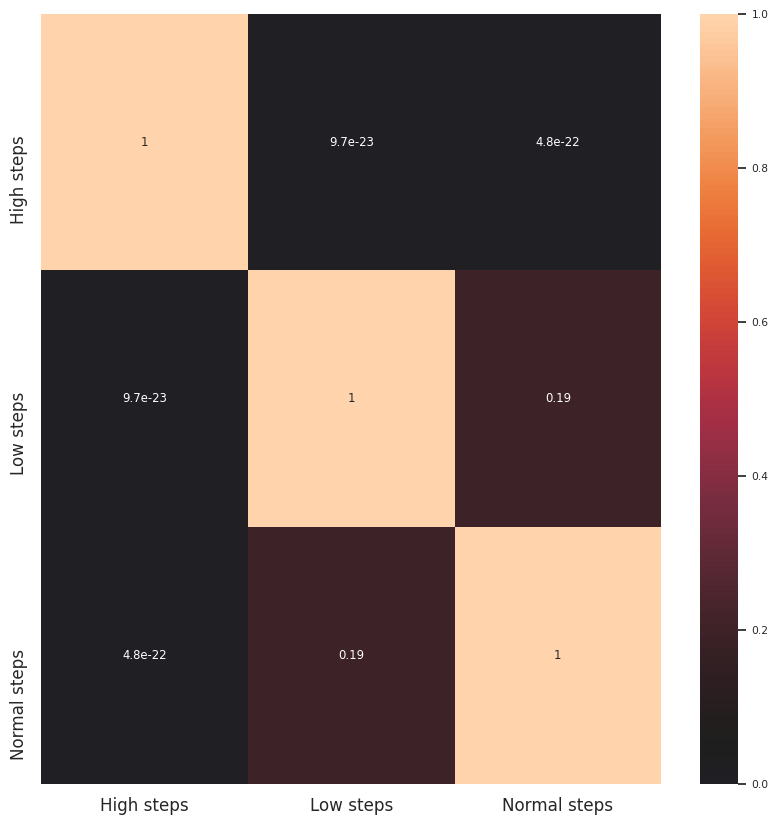

In [180]:
f, ax = plt.subplots(figsize=(10, 10))
sns.set(font_scale=.7)
ax=sns.heatmap(df_p.pivot('A','B','p'), annot=True, center=0.05,)
ax.set(xlabel="", ylabel="")

/tmp/ipykernel_3036824/4077407785.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_p.pivot('A','B','p'),


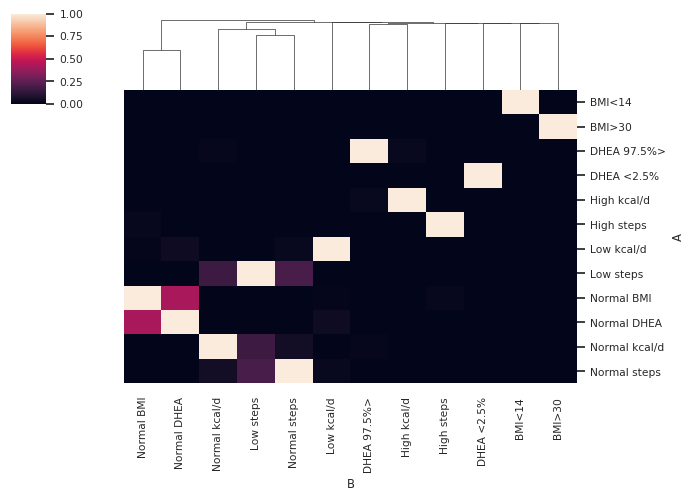

In [146]:
sns.clustermap(
    df_p.pivot('A','B','p'),
    figsize=(7, 5),
    row_cluster=False,
    #dendrogram_ratio=(.1, .2),
    #cbar_pos=(0, .2, .03, .4)
)

In [24]:
df_p

,A,B,p
0,Normal BMI,Normal BMI,1.000000e+00
1,Normal BMI,BMI<14,7.837914e-67
2,Normal BMI,BMI>30,2.968857e-227
3,Normal BMI,Normal DHEA,4.176403e-01
4,Normal BMI,DHEA <2.5%,4.698644e-22
...,...,...,...
191,DMG,Normal kcal/d,1.121274e-15
192,DMG,Low kcal/d,2.249206e-14
193,DMG,High kcal/d,6.973091e-11
194,DMG,pLGG,1.764155e-01
